### Python Packages

In [17]:
import os

import biotite.sequence.io.fasta as bioseq
import biotite.structure.io as strucio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from Bio import AlignIO
from Bio.PDB import PDBIO, PDBParser
from matplotlib import patches
from matplotlib.patches import Patch


### Convert Sequence Header info into CSV

In [18]:
def header_breakdown(fasta_directory:str) -> pd.DataFrame:
    # import fasta file
    fasta_file = bioseq.FastaFile()
    fasta_file.read(fasta_directory)
    sequences = bioseq.get_sequences(fasta_file)

    # Extract headers from sequence keys
    headers = list(sequences.keys())

    # Convert headers to DataFrame and split by delimiters ~, -, /
    df = pd.DataFrame(headers, columns=["initial_header"])
    df = df["initial_header"].str.split("~|-|/", expand=True)

    # Get unique non-null values from columns 2, 3, 4
    unique_values = pd.unique(df.iloc[:, 2:5].values.ravel())
    unique_values = unique_values[~pd.isna(unique_values)]

    # Create new columns based on unique values presence
    for value in unique_values:
        df[value] = df.iloc[:, 2:5].apply(lambda x: value in x.values, axis=1)

    # Retain necessary columns and sort them
    df = df.drop(columns=[2, 3, 4])
    df = df[[0, 1] + sorted(unique_values.tolist())]

    # Rename columns and set the "Positive_control" column
    df.columns = ["accession_id", "Positive_control"] + df.columns[2:].tolist()
    df["Positive_control"] = df["Positive_control"].str.contains("Positive_Control", case=False, na=False)

    # Add the original headers back as the first column
    df.insert(0, "initial_header", headers)

    # Add sequence string to end
    df["Sequence"] = df["initial_header"].map(sequences)
    # convert list of characters to string
    df["Sequence"] = df["Sequence"].apply(lambda x: "".join(x))

    return df

In [19]:
# Save header data to a CSV file
header_df = header_breakdown("sequences/p450_edit.fasta")
header_df.to_csv("sequences/p450_header_breakdown.csv", index=False)

### Uniprot pepsearch

In [20]:
pepsearch = pd.read_csv("uniprot_pepsearch/pepsearch_batch_concat.tsv", sep="\t")

# join header data with pepsearch data on Sequence
merged_df = pd.merge(header_df[["initial_header", "accession_id", "Sequence"]], pepsearch, on="Sequence", how="left")

# drop rows with no uniprot entry
merged_df = merged_df.dropna(subset=["Entry"])
merged_df = merged_df.drop(columns=["Sequence"])

# Save merged data to a CSV file
merged_df.to_csv("uniprot_pepsearch/p450_uniprot_matches.csv", index=False)

### Translate and rotate pdb files to align Q9LVY7.1~NA-C_28

In [21]:
def transform_pdb(
        pdb_file: str,
        flat_rot_str: str,
        flat_trans_str: str,
        output_file: str) -> None:
    """
    Transform a PDB file by applying a rotation then translation from foldseek.
    
    Parameters
    ----------
    pdb_file : str
        Path to the PDB file.
    flat_rot_str : str
        A string of 9 comma-separated floats representing a 3x3 rotation matrix
        in row-major order.
    flat_trans_str : str
        A string of 3 comma-separated floats representing a translation vector.
    output_file : str
        Path to the output file.
    """
    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure(pdb_file[:-4], pdb_file)

    # Convert the flat rotation matrix string into a list of floats and reshape it into a 3x3 matrix
    flat_rot = [float(x) for x in flat_rot_str.split(",")]
    rot = np.array(flat_rot).reshape(3, 3)

    # Convert the flat translation vector string into a list of floats
    flat_trans = [float(x) for x in flat_trans_str.split(",")]
    trans = np.array(flat_trans)

    # Apply the translation and rotation to each atom
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    # Translate
                    atom.coord -= trans
                    # Rotate
                    atom.transform(rot, np.zeros(3))

    # Save the transformed structure
    io = PDBIO()
    io.set_structure(structure)
    if not output_file:
        output_file = pdb_file + "_transformed.pdb"
    io.save(output_file)

In [22]:
# load foldseek data
foldseek = pd.read_csv("foldseek/foldseek_results.tsv", sep="\t")

# filter df for rows where Q9LVY7_1_NA_C_28.pdb is the target
foldseek_target = foldseek[foldseek["target"] == "Q9LVY7_1_NA_C_28"]

foldseek_target.apply(lambda row: transform_pdb(f"Alphafold/alphafold_structures/{row["query"]}.pdb",
                                                row["u"],
                                                row["t"],
                                                f"foldseek/aligned_structures/{row["query"]}.pdb"), axis=1)

22       None
172      None
302      None
435      None
611      None
         ... 
16298    None
16432    None
16572    None
16650    None
16821    None
Length: 130, dtype: object

### Get the average pLDDT score for each predicted structure

In [23]:
def get_plddt(directory:str)->pd.DataFrame:
    """
    Calculate the average pLDDT score for each structure in the directory.

    Parameters
    ----------
    directory : str
        The directory containing the PDB files.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the filename and average pLDDT score of each structure.
    """

    # List to store average B-factors
    avg_bfactors = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            filepath = os.path.join(directory, filename)

            # Load the structure
            test = strucio.load_structure(filepath, extra_fields=["b_factor"])

            # Extract B-factors and convert to list
            bfactor = test.b_factor[0::].tolist()

            # Calculate average B-factor
            avg_bfactor = sum(bfactor) / len(bfactor)

            # Store the result
            avg_bfactors.append((filename, avg_bfactor, bfactor))

    return pd.DataFrame(avg_bfactors, columns=["Filename", "Average pLDDT", "per-residue pLDDT"])

def plddt_hist(column: pd.Series,
              xlabel: str="value",
              ylabel: str="count",
              title: str="Title")->None:
    """
    Create a histogram of pLDDT scores with custom color coding.

    Parameters
    ----------
    column : pandas.Series
        The column containing the pLDDT scores.
    xlabel : str, optional
        The label for the x-axis.
    ylabel : str, optional
        The label for the y-axis.
    title : str, optional
        The title of the plot.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot histogram with specified range and bin size
    n, bins, patches = ax.hist(column,
                            range=(0, 100),
                            bins=50)

    # Color the histogram bars based on the interval they are within
    for patch, left, right in zip(patches, bins[:-1], bins[1:]):
        if left >= 90:
            patch.set_facecolor("#0053d6")
        elif left >= 70:
            patch.set_facecolor("#65cbf3")
        elif left >= 50:
            patch.set_facecolor("#ffdb13")
        else:
            patch.set_facecolor("#ff7d45")
        patch.set_alpha(0.9)

    ax.set_xlim(0, 100)

    # Add labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Create custom legend
    legend_patches = [
        Patch(color="#0053d6", label="Very High (90-100)"),
        Patch(color="#65cbf3", label="High (70-90)"),
        Patch(color="#ffdb13", label="Low (50-70)"),
        Patch(color="#ff7d45", label="Very Low (0-50)")
    ]
    ax.legend(handles=legend_patches,
            loc="upper left",
            bbox_to_anchor=(1, 1),
            title="pLDDT Confidence Levels")
    
    # Show plot
    plt.show()

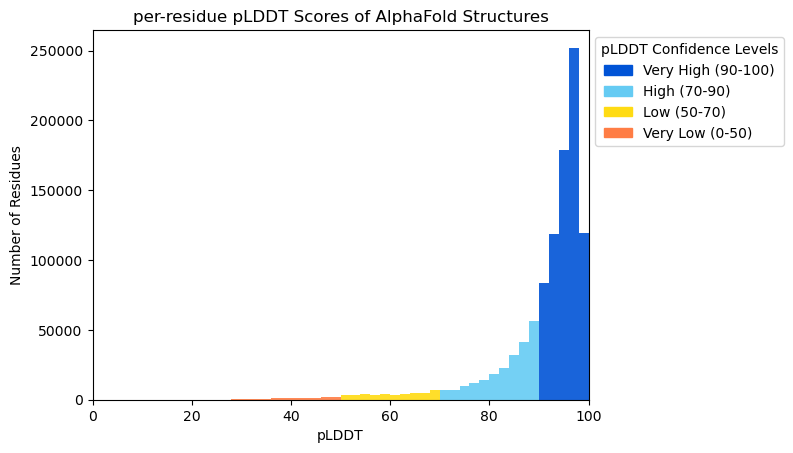

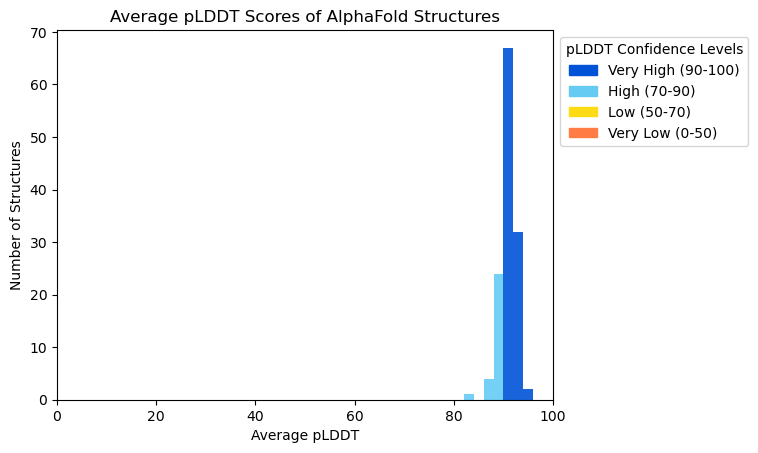

In [24]:
avg_plddt = get_plddt("Alphafold/alphafold_structures")

plddt_hist(np.concatenate(avg_plddt["per-residue pLDDT"].values),
          xlabel="pLDDT",
          ylabel="Number of Residues",
          title="per-residue pLDDT Scores of AlphaFold Structures")

plddt_hist(avg_plddt["Average pLDDT"],
          xlabel="Average pLDDT", 
          ylabel="Number of Structures",
          title="Average pLDDT Scores of AlphaFold Structures")

### InterproScan Family Analysis

In [25]:
# Read the CSV file
panther = pd.read_csv("panther/p450_panther.tsv", sep="\t", header=None)

# add column names
panther.columns = ["accession_id", "panther_family", "description", "evalue", "bitscore", "start-stop"]

def create_panther_bool(panther_df):
    # Keep only the first two columns
    panther = panther_df.iloc[:, :2]

    # split the panther_family column into two columns by :
    panther[["panther_family", "panther_subfamily"]] = panther["panther_family"].str.split(":", expand=True)

    panther_fam = panther[["accession_id", "panther_family"]]
    panther_subfam = panther[["accession_id", "panther_subfamily"]]

    # Pivot table such that column 2 is column headers and True/False values
    panther_fam = panther_fam.pivot_table(index="accession_id",
                                columns="panther_family",
                                aggfunc=lambda x: True,
                                fill_value=False).reset_index()

    panther_subfam = panther_subfam.pivot_table(index="accession_id",
                                columns="panther_subfamily",
                                aggfunc=lambda x: True,
                                fill_value=False).reset_index()

    # merge panther_fam and panther_subfam
    panther = pd.merge(panther_fam, panther_subfam, on="accession_id", how="left")

    return panther

panther_bool = create_panther_bool(panther)

panther_split = panther
panther_split[["panther_family", "panther_subfamily"]] = panther_split["panther_family"].str.split(":", expand=True)

# Save panther data to a CSV file
panther_split.to_csv("panther/p450_panther_split.csv", index=False)

In [26]:
interproscan = pd.read_csv("interproscan/interproscan_p450.tsv", sep="\t", header=None)

def get_familes(interproscan_df):

    interpro_famlies = interproscan_df[[0, 11, 12]]
    interpro_famlies = interpro_famlies[~interpro_famlies[11].str.contains("-")]
    interpro_famlies.columns = ["accession_id", "family", "family_description"]


    return interpro_famlies

interpro_famlies = get_familes(interproscan)

# family descriptions
fam_desc = interpro_famlies[["family", "family_description"]].drop_duplicates()
fam_desc.to_csv("interproscan/interproscan_p450_fam_desc.csv", index=False)

interpro_famlies = interpro_famlies[["accession_id", "family"]]
interpro_famlies = interpro_famlies.pivot_table(index="accession_id",
                                                columns="family",
                                                aggfunc=lambda x: True,
                                                fill_value=False)

# join with substrate specificity data from header_df
def join_datframes(interpro_famlies, header_df, panther):
    # drop unnecessary columns
    header_df = header_df.drop(columns=["accession_id", "Sequence", "Positive_control"])
    # rename intial_header to accession_id
    header_df = header_df.rename(columns={"initial_header": "accession_id"})

    # merge the two dataframes
    merged_df = pd.merge(header_df, interpro_famlies, on="accession_id", how="left")

    # remove alpha characters from accession_id
    merged_df["accession_id"] = merged_df["accession_id"].str.replace("α", "", regex=False)

    # replace accession_id special chacters with _
    merged_df["accession_id"] = merged_df["accession_id"].str.replace(r"[^a-zA-Z0-9]", "_", regex=True)

    # merge interpro to panther
    merged_df = pd.merge(merged_df, panther, on="accession_id", how="left")

    return merged_df

interpro_famlies = join_datframes(interpro_famlies, header_df, panther_bool)

interpro_groups = interpro_famlies[["accession_id", "IPR002403", "IPR002401"]].copy()

# combine "IPR002403", "IPR002401" into one column with "IPR002403", "IPR002401" as the values depending True/False
interpro_groups.loc[:, "IPR002403"] = interpro_groups["IPR002403"].apply(lambda x: "IPR002403" if x else "")
interpro_groups.loc[:, "IPR002401"] = interpro_groups["IPR002401"].apply(lambda x: "IPR002401" if x else "")
interpro_groups.loc[:, "interpro"] = interpro_groups["IPR002403"] + interpro_groups["IPR002401"]

# drop "IPR002403", "IPR002401" columns
interpro_groups = interpro_groups.drop(columns=["IPR002403", "IPR002401"])

# Save interpro data to a CSV file
interpro_groups.to_csv("interproscan/interproscan_p450_group.csv", index=False)


/tmp/ipykernel_1646170/2331996197.py:50: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' 'IPR002403' 'IPR002403' 'IPR002403'
 'IPR002403' 'IPR002403' '' '' '' '' 'IPR002403' 'IPR002403' '' '' '' ''
 '' '' 'IPR002403' '' '' '' 'IPR002403' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' 'IPR002403' '' '' 'IPR002403'
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' 'IPR002403' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' 'IPR002403' '' '' 'IPR002403'
 'IPR002403' '' '' '' '']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_1646170/2331996197.py:51: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IPR002401' 'IPR002401' 'IPR002401' 'IPR002401' 'IPR00240

### Functions for Sankey Diagram

In [27]:
levels_dict = {
    "Level 0": ["IPR036396"],
    "Level 1": ["IPR001128"],
    "Level 2": ["IPR002403", "IPR002401"],
    "level 3": ["PTHR24286", "PTHR24282", "PTHR24298", "PTHR47956", "PTHR24281"],
    "level 4": ["SF331", "SF349", "SF53", "SF339", "SF199", "SF296", "SF40",
                "SF368", "SF369", "SF10", "SF258", "SF361", "SF305", "SF327",
                "SF362", "SF366", "SF374", "SF88", "SF253", "SF160", "SF196",
                "SF20", "SF251", "SF63", "SF678", "SF630", "SF901", "SF475",
                "SF54", "SF142", "SF22", "SF72", "SF138", "SF113"],
}
node_levels = list(levels_dict.values())

labels = [item for sublist in node_levels for item in sublist]

node_levels_index = []
current_index = 0
for sublist in node_levels:
    node_levels_index.append(list(range(current_index, current_index + len(sublist))))
    current_index += len(sublist)

def prepare_sankey_data(interpro_famlies, levels_dict):

    # List to hold the source and target pairs
    source_target_pairs = []

    # Get the list of keys
    keys = list(levels_dict.keys())

    # Iterate through the dictionary comparing each level with the next
    for i in range(len(keys) - 1):
        # Current level values
        current_level = levels_dict[keys[i]]
        # Next level values
        next_level = levels_dict[keys[i + 1]]

        # Ensure that values are lists for uniform processing
        if not isinstance(current_level, list):
            current_level = [current_level]
        if not isinstance(next_level, list):
            next_level = [next_level]

        # Create source-target pairs
        for source in current_level:
            for target in next_level:
                source_target_pairs.append((source, target))

    # Convert the list to a DataFrame
    df = pd.DataFrame(source_target_pairs, columns=["source", "target"])

    # Step 2: Add the "values" column
    values = []
    for _, row in df.iterrows():
        source = row["source"]
        target = row["target"]
        
        # Count the number of rows where both source and target columns are True
        count = interpro_famlies[(interpro_famlies[source]) & (interpro_famlies[target])].shape[0]
        
        values.append(count)

    df["values"] = values

    # step 3 drop rows with 0 values
    df = df[df["values"] != 0]

    # Step 4: Replace source and target with their index values from labels
    df["source"] = df["source"].apply(lambda x: labels.index(x))
    df["target"] = df["target"].apply(lambda x: labels.index(x))

    # Step 5: Return source, target, and values as lists
    sources = df["source"].tolist()
    targets = df["target"].tolist()
    values = df["values"].tolist()

    return labels, sources, targets, values

def node_width(source, target, value):
    # Get unique nodes
    nodes = list(set(source + target))
    
    # Initialize dictionaries for incoming and outgoing totals
    incoming_totals = {node: 0 for node in nodes}
    outgoing_totals = {node: 0 for node in nodes}
    
    # Calculate incoming totals
    for i in range(len(source)):
        incoming_totals[target[i]] += value[i]
    
    # Calculate outgoing totals
    for i in range(len(target)):
        outgoing_totals[source[i]] += value[i]
    
    # Compute the maximum of incoming or outgoing totals for each node
    node_values = {node: max(incoming_totals[node], outgoing_totals[node]) for node in nodes}

    # convert to list
    node_values = [node_values[node] for node in nodes]
    
    return node_values

def nodify(node_levels_index, node_widths):

    level_index = node_levels_index
    
    n_levels = len(level_index)

    nodes_total = len(node_widths)

    # evenly space each each level along x from 0 to 1
    level_x_pos = []
    for i in range(n_levels):
        nodes_at_level = level_index[i]
        n_nodes = len(nodes_at_level)
        if i == 0:
            level_x_pos.append([1e-9] * n_nodes)
        elif i == n_levels-1:
            level_x_pos.append([1-1e-9] * n_nodes)
        else:
            level_x_pos.append([i/(n_levels-1)] * n_nodes)
    
    # order the x_pos based on the node index
    x_pos = []
    for i in range(nodes_total):
        for j in range(n_levels):
            if i in level_index[j]:
                x_pos.append(level_x_pos[j][level_index[j].index(i)])

    # evenly space each node within each level along y from 0 to 1
    y_pos = []
    for i in range(n_levels):
        nodes_at_level = level_index[i]
        n_nodes = len(nodes_at_level)
        if n_nodes == 1:
            y_pos.append(0.5)
            continue
        gamma = 0.2/(n_nodes-1)
        level_width = sum([node_widths[node] for node in nodes_at_level])
        scale_factor = (1-gamma*(n_nodes-1))
        for j in range(n_nodes):
            node_width_norm = node_widths[nodes_at_level[j]]/level_width*scale_factor
            if j == 0:
                previous_width = node_width_norm
                y_pos_j = node_width_norm/2
                y_pos.append(y_pos_j)
            else:
                y_pos_j = y_pos[-1] + previous_width/2 + gamma + node_width_norm/2
                y_pos.append(y_pos_j)
                previous_width = node_width_norm

    # reorder y positions based on level index
    y_pos_new = []
    for levels in level_index:
        for node in levels:
            y_pos_new.append(y_pos[node])
    y_pos = y_pos_new 
    
    return x_pos, y_pos

labels, source, target, value = prepare_sankey_data(interpro_famlies, levels_dict)
node_widths = node_width(source, target, value)
nodified = nodify(node_levels_index, node_widths)

In [28]:
# Create the Sankey diagram

fig = go.Figure(data=[go.Sankey(
    arrangement = "perpendicular",
    node = {
      "pad": 10,
      "thickness": 20,
      "line": {"color": "black", "width": 0.5},
      "label": labels,
      "x": nodified[0],
      "y": nodified[1],
    },
    link = {
      "source": source,
      "target": target,
      "value": value
  })])

# Update the layout to change the plot area
fig.update_layout(
    font_size=12,
    width=800,  # Set the width of the plot area
    height=800,  # Set the height of the plot area
    margin={"l": 50, "r": 50, "t": 50, "b": 50}  # Set the margins
)

fig.show()

In [29]:
def subfamily_specificty(df, panther):
    # Initialize the results list
    results = []

    # Identify the unique PTHR and SF columns
    pthr_columns = [col for col in df.columns if col.startswith("PTHR")]
    sf_columns = [col for col in df.columns if col.startswith("SF")]

    # Iterate through each combination of PTHR and SF columns
    for pthr in pthr_columns:
        for sf in sf_columns:
            # Filter the data for rows where both PTHR and SF are True
            subfamily_data = df[df[pthr] & df[sf]]
            num_sequences = subfamily_data.shape[0]
            
            if num_sequences > 0:
                # Count the occurrences for each C_ category
                specificity_counts = {}
                for col in df.columns:
                    if col.startswith("C_"):
                        count = subfamily_data[col].sum()
                        if count > 0:
                            specificity_counts[col] = count
                
                # Calculate total counts
                total_counts = sum(specificity_counts.values())
                
                # Calculate percentages and sort by descending order
                sorted_specificity = sorted(specificity_counts.items(), 
                                            key=lambda item: (item[1] / total_counts), 
                                            reverse=True)
                
                # Create specificity string without underscores
                specificity_str = "/".join(key.replace("_", "") for key, _ in sorted_specificity)
                percentages_str = "/".join(str(round((count / total_counts) * 100)) 
                                           for _, count in sorted_specificity)
                
                specificity = f"{specificity_str} ({percentages_str})"
                
                # Construct the full Panther Subfamily identifier
                full_subfamily = f"{pthr}:{sf}"
                results.append([full_subfamily, num_sequences, specificity])

    # Create the final results DataFrame
    panther_specificty = pd.DataFrame(results, columns=["panther_family", "Sequences", "Specificity"])

    # Arrange df by decreasing number of sequences then by subfamily
    panther_specificty = panther_specificty.sort_values(by=["Sequences", "panther_family"], ascending=[False, True])

    # Add subfamily descriptions from the panther data
    panther_desc = panther[["panther_family", "description"]].drop_duplicates()
    panther_specificty = pd.merge(panther_specificty, panther_desc, left_on="panther_family", right_on="panther_family", how="left")

    # reorder columns
    panther_specificty = panther_specificty[["panther_family", "description", "Sequences", "Specificity"]]

    return panther_specificty

panther_specificty = subfamily_specificty(interpro_famlies, panther)

# save the data to a csv file
panther_specificty.to_csv("panther/panther_specificity.csv", index=False)

### Alignment

In [30]:
def column_occupancy(fasta_file: str) -> list:
    """
    Calculate the occupancy of each column in a multiple sequence alignment (MSA).

    Parameters
    ----------
    fasta_file : str
        The path to a FASTA file containing the MSA

    Returns
    -------
    list
        A list of occupancy scores for each column in the MSA
    """
    # Read the MSA from the FASTA file
    alignment = AlignIO.read(fasta_file, "fasta")
    
    # Initialize a list to store the occupancy of each column
    occupancy = []
    
    # Loop through each column of the alignment
    for i in range(alignment.get_alignment_length()):
        column = alignment[:, i]

        # 1-occupancy
        occupancy.append(1 - column.count("-") / len(column))
    
    return occupancy

def harmonic_mean(lst1: list, lst2: list) -> list:
    """
    Calculate the harmonic mean of two lists of numbers.

    Parameters
    ----------
    lst1 : list
        A list of numbers
    lst2 : list
        A second list of numbers

    Returns
    -------
    A list of harmonic means
    """
    lst = zip(lst1, lst2)
    hm = [0 if lst1 == 0 or lst2 == 0 
          else 2 / ((1/lst1) + (1/lst2)) 
          for lst1, lst2 in lst]
    
    return hm

def plot_foldmason_scores(
        occupancy: list, 
        lddt: list, 
        title: str ="Alignment Scores") -> None:
    """
    Plot the occupancy and lddt scores for a given alignment, along with the harmonic 
    mean of the two scores.

    Parameters
    ----------
    occupancy : list
        A list of occupancy scores for each column in the alignment
    lddt : list
        A list of lddt scores for each column in the alignment
    title : str
        The title of the plot
    
    Returns
    -------
    A plot of the occupancy and lddt scores for each column in the alignment, along 
    with the harmonic mean of the two scores.

    """
    # Set up the figure with a 3x2 subplot grid
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 6),
                        gridspec_kw={"height_ratios": [1, 1, 10], "width_ratios": [40, 1]})

    # Occupancy Color Bar Plot [Row 0, Column 0]
    cmap = plt.cm.viridis
    for i, val in enumerate(occupancy):
        color = cmap(val / max(occupancy))
        rect = patches.Rectangle((i, 0), 1, 1, color=color)
        axs[0, 0].add_patch(rect)

    axs[0, 0].set_xlim(0, len(occupancy))
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].axis("off")

    # Occupancy Label [Row 0, Column 1]
    axs[0, 1].axis("off")
    axs[0, 1].text(-1.8, 0.5, "Column Occupancy", ha="left", va="center", fontsize=11)

    # LDDT Color Bar Plot [Row 1, Column 0]
    for i, val in enumerate(lddt):
        color = cmap(val / max(lddt))
        rect = patches.Rectangle((i, 0), 1, 1, color=color)
        axs[1, 0].add_patch(rect)

    axs[1, 0].set_xlim(0, len(lddt))
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].axis("off")

    # LDDT Label [Row 1, Column 1]
    axs[1, 1].axis("off")
    axs[1, 1].text(-1.8, 0.5, "Column LDDT Score", ha="left", va="center", fontsize=11)

    # Harmonic Mean Plot [Row 2, Column 0]
    hm = harmonic_mean(occupancy, lddt)
    axs[2, 0].plot(hm, color="black")
    axs[2, 0].fill_between(np.arange(len(hm)), hm, color="black", alpha=0.3)

    # Adjust the plot limits and labels
    axs[2, 0].set_xlim(0, len(occupancy))
    axs[2, 0].set_ylim(0, 1)
    axs[2, 0].set_xlabel("Alignment Index")
    axs[2, 0].set_ylabel("Harmonic Mean (Column Occupancy & LDDT)")
    axs[0, 0].set_title(title)

    # Colorbar scale for occupancy and lddt scores [Row 2, Column 1]
    norm = plt.Normalize(vmin=min(occupancy + lddt), vmax=max(occupancy + lddt))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=axs[2, 1])

    # Adjust layout and show plot
    plt.subplots_adjust(hspace=0.01, wspace=0.1)
    plt.show()

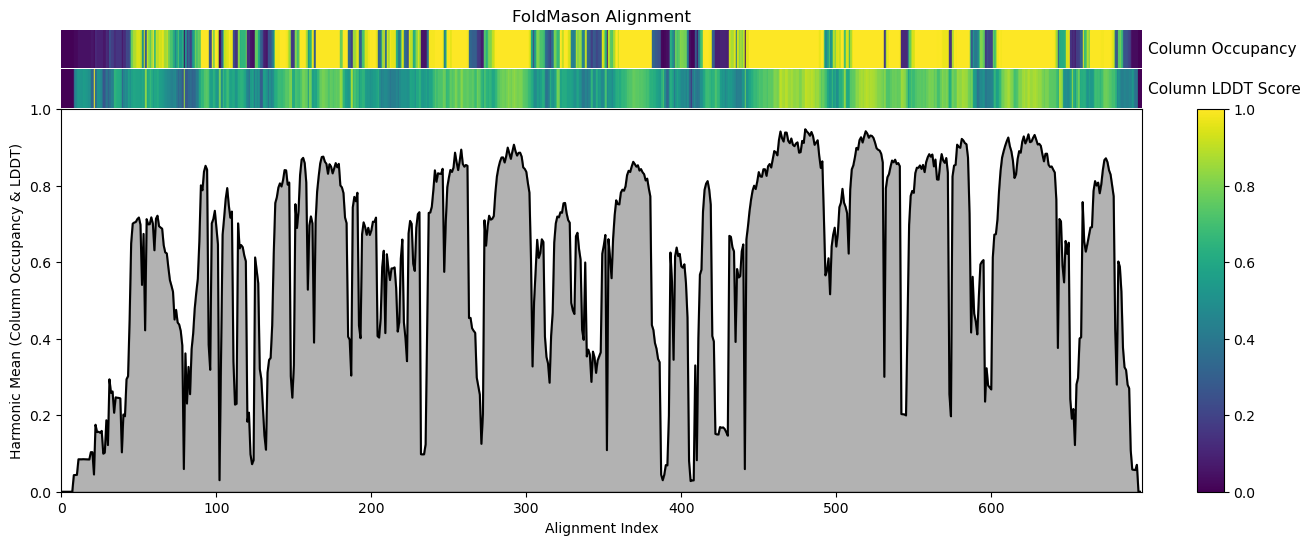

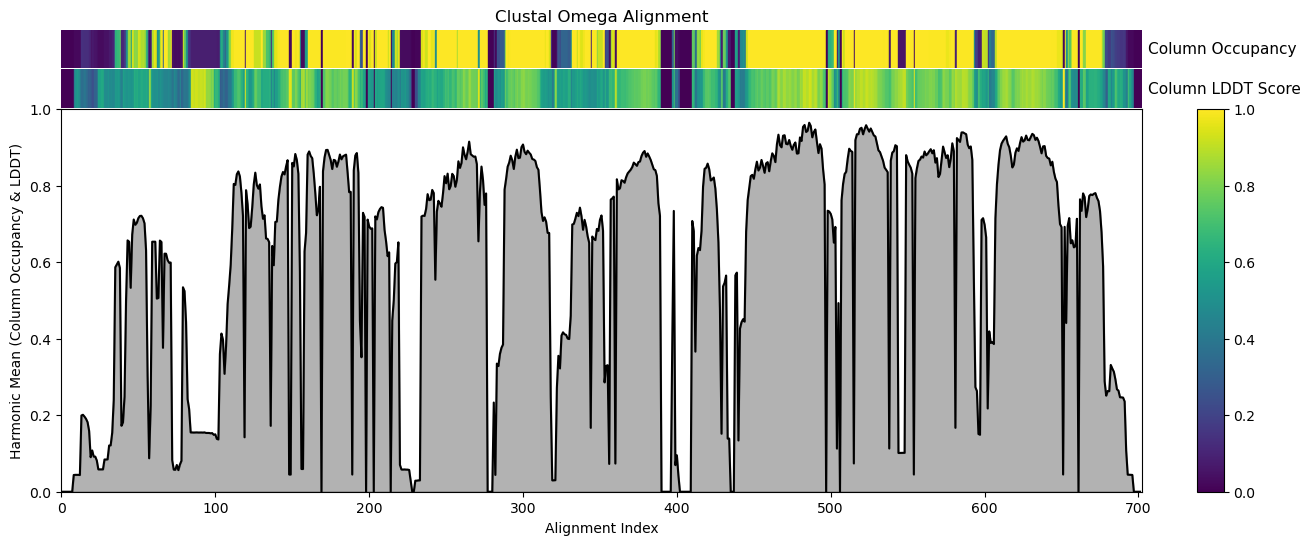

In [31]:
foldmason_oc = column_occupancy("alignments/foldmason/foldmason_aln_aa.fasta")
foldmason_lddt = pd.read_csv("alignments/foldmason/foldmason_column_lddts.csv")
foldmason_lddt = foldmason_lddt["LDDT Score"].tolist()

clustal_oc = column_occupancy("alignments/clustalo/clustalo_seq_aln.fasta")
clustal_lddt = pd.read_csv("alignments/clustalo/clustalo_column_lddts.csv")
clustal_lddt = clustal_lddt["LDDT Score"].tolist()

plot_foldmason_scores(foldmason_oc, foldmason_lddt, title = "FoldMason Alignment")
plot_foldmason_scores(clustal_oc, clustal_lddt, title = "Clustal Omega Alignment")


In [32]:
# Read the MSA from the FASTA file
alignment = AlignIO.read("alignments/foldmason/foldmason_aln_aa.fasta", "fasta")

# Define the sequence ID you are interested in
sequence_id = "Q9LVY7_1_NA_C_28"

# Iterate through the alignment to find the sequence
for record in alignment:
    if record.id == sequence_id:
        seq = record.seq

# Collect indices of non-gap characters
non_gap_positions = [i for i, char in enumerate(seq) if char != "-"]

# get corresponding foldmason lddt scores
seq_foldmason_lddt = [foldmason_lddt[i] for i in non_gap_positions]

# replace PDB b-factors with foldmason lddt scores
def replace_bfactors_for_residues(input_pdb, output_pdb, bfactor_list):
    """
    This function reads a PDB file using PDBParser, replaces the B-factor values for each residue,
    and writes the updated structure to a new PDB file. The B-factor of all atoms in a residue
    is replaced by the value from bfactor_list.

    :param input_pdb: Path to the input PDB file
    :param output_pdb: Path to the output PDB file where changes will be saved
    :param bfactor_list: List of new B-factor values (one per residue)
    """
    
    # Initialize PDB parser and IO
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", input_pdb)
    io = PDBIO()

    # Index for iterating through the bfactor_list
    bfactor_index = 0

    # Iterate through models, chains, and residues
    for model in structure:
        for chain in model:
            for residue in chain:
                if bfactor_index >= len(bfactor_list):
                    raise ValueError("The provided B-factor list has fewer values than the number of residues in the PDB file.")

                # Get the B-factor for this residue from the list
                new_bfactor = bfactor_list[bfactor_index]

                # Set the B-factor for all atoms in the current residue
                for atom in residue:
                    atom.set_bfactor(new_bfactor)

                bfactor_index += 1

    # Save the modified structure to a new PDB file
    io.set_structure(structure)
    io.save(output_pdb)

# Replace the B-factors in the PDB file
replace_bfactors_for_residues("Alphafold/alphafold_structures/Q9LVY7_1_NA_C_28.pdb",
                              "alignments/foldmason/Q9LVY7_lddt_bfactors.pdb",
                              seq_foldmason_lddt)
